# Creating layer class

In [2]:
import numpy as np
import nnfs
from nnfs.datasets import spiral_data
import matplotlib.pyplot as plt

In [3]:
np.random.seed(0)
nnfs.init()

# Neural layer class

In [4]:
class Layer_Dense:
    def __init__(self, n_inputs, n_neurons):
        self.weights = 0.10 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))
        
    def forward(self, inputs):
        self.inputs = inputs # Remember inputs for backpropagation
        self.output = np.dot(inputs, self.weights) + self.biases

    def backward(self, dvalues):
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)

        # Calculate gradient on inputs
        self.dinputs = np.dot(dvalues, self.weights.T)

# Creating ReLu Activation Function

In [5]:
class Activation_ReLU:
    def forward(self, inputs):
        self.inputs = inputs # Remember inputs for backpropagation
        
        self.output = np.maximum(0, inputs)

    def backward(self, dvalues):
        self.dinputs = dvalues.copy()
        
        # Calculate gradient on inputs
        self.dinputs[self.inputs <= 0] = 0

# Softmax Activation Function

In [6]:
class Activation_Softmax:
    def forward(self, inputs):
        self.inputs = inputs # Remember inputs for backpropagation
        
        exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
        probabilities = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        
        self.output = probabilities

    def backward(self, dvalues):
        self.dinputs = np.empty_like(dvalues)

        for index, (single_output, single_dvalues) in enumerate(zip(self.output, dvalues)):

            single_output = single_output.reshape(-1, 1)
            jacobian_matrix = np.diagflat(single_output) - np.dot(single_output, single_output.T)

            self.dinputs[index] = np.dot(jacobian_matrix, single_dvalues)

# Categorical Cross-Entropy Loss Function

In [7]:
class Loss:    
    def calculate(self, output, y):
        sample_losses = self.forward(output, y)
        data_loss = np.mean(sample_losses)
        
        return data_loss

class Loss_CategoricalCrossEntropy(Loss):
    def forward(self, y_pred, y_true):
        samples = len(y_pred)
        y_pred_clipped = np.clip(y_pred, 1e-7, 1-1e-7)

        # Check shape of targets
        if len(y_true.shape) == 1:
            # Data is [0,1,0]...
            correct_confidences = y_pred_clipped[range(samples), y_true]
        elif len(y_true.shape) == 2:
            # Data is [[1,0],[0,1],[1,0]]
            correct_confidences = np.sum(y_pred_clipped*y_true, axis=1)
        
        negative_log_likelihoods = -np.log(correct_confidences)
        return negative_log_likelihoods

    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        labels = len(dvalues[0])

        # Turn labelse into one-hot vector
        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]

        # Calculate gradient on inputs
        self.dinputs = -y_true / dvalues
        self.dinputs = self.dinputs / samples # Normalize

# Softmax combined with Categorical Cross-Entropy

In [8]:
class Activation_Softmax_Loss_CategoricalCrossentropy():
    def __init__(self):
        self.activation = Activation_Softmax()
        self.loss = Loss_CategoricalCrossEntropy()

    def forward(self, inputs, y_true):
        self.activation.forward(inputs)
        self.output = self.activation.output

        # Calculate loss
        return self.loss.calculate(self.output, y_true)

    def backward(self, dvalues, y_true):
        samples = len(dvalues)

        # Reshape targets if [[0,1], [1,0]]
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)

        self.dinputs = dvalues.copy()

        # Calculate gradient on inputs
        self.dinputs[range(samples), y_true] -= 1
        self.dinputs = self.dinputs / samples

# Stochastic Gradient Descent optimizer

In [9]:
class Optimizer_SGD():
    def __init__(self, learning_rate=1, decay=0, momentum=0):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.momentum = momentum

    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1 / (1 + self.decay * self.iterations))
    
    def update_params(self, layer):
        if self.momentum:
            # Uses momentum
            if not hasattr(layer, 'weight_momentums'):
                layer.weight_momentums = np.zeros_like(layer.weights)
                layer.bias_momentums = np.zeros_like(layer.biases)

            # Weight updates
            weight_updates = self.momentum * layer.weight_momentums - self.current_learning_rate * layer.dweights
            layer.weight_momentums = weight_updates

            # Bias updates
            bias_updates = self.momentum * layer.bias_momentums - self.current_learning_rate * layer.dbiases
            layer.bias_momentums = bias_updates
            
        else:
            layer.weights += -self.current_learning_rate * layer.dweights
            layer.biases += -self.current_learning_rate * layer.dbiases

        layer.weights += weight_updates
        layer.biases += bias_updates

    def post_update_params(self):
        self.iterations += 1

# Adam Optimizer

In [10]:
class Optimizer_Adam:
    def __init__(self, learning_rate=0.001, decay=0., epsilon=1e-7, beta_1=0.9, beta_2=0.999):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.beta_1 = beta_1
        self.beta_2 = beta_2
    
    # Call once before any parameter updates
    def pre_update_params(self): 
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1. / (1. + self.decay * self.iterations))
    
    # Update parameters
    def update_params(self, layer):
        # If layer does not contain cache arrays, create them filled with zeros
        if not hasattr(layer, 'weight_cache'):
            layer.weight_momentums = np.zeros_like(layer.weights)
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_momentums = np.zeros_like(layer.biases)
            layer.bias_cache = np.zeros_like(layer.biases)
            
        # Update momentum  with current gradients
        layer.weight_momentums = self.beta_1 * layer.weight_momentums + (1 - self.beta_1) * layer.dweights
        layer.bias_momentums = self.beta_1 * layer.bias_momentums + (1 - self.beta_1) * layer.dbiases
        
        # Get corrected momentum
        weight_momentums_corrected = layer.weight_momentums / (1 - self.beta_1 ** (self.iterations + 1))
        bias_momentums_corrected = layer.bias_momentums / (1 - self.beta_1 ** (self.iterations + 1))
        
        # Update cache with squared current gradients
        layer.weight_cache = self.beta_2 * layer.weight_cache + (1 - self.beta_2) * layer.dweights**2
        layer.bias_cache = self.beta_2 * layer.bias_cache + (1 - self.beta_2) * layer.dbiases**2
        
        # Get corrected cache
        weight_cache_corrected = layer.weight_cache / (1 - self.beta_2 ** (self.iterations + 1))
        bias_cache_corrected = layer.bias_cache / (1 - self.beta_2 ** (self.iterations + 1))
        
        # Vanilla SGD parameter update + normalization
        layer.weights += -self.current_learning_rate * weight_momentums_corrected / (np.sqrt(weight_cache_corrected) + self.epsilon)
        layer.biases += -self.current_learning_rate * bias_momentums_corrected / (np.sqrt(bias_cache_corrected) + self.epsilon)

    # Call once after any parameter updates
    def post_update_params(self): 
        self.iterations += 1

# Zalando Dataset

In [11]:
import os
import cv2

In [12]:
def load_mnist_dataset(dataset, path):
    labels = sorted(os.listdir(os.path.join(path, dataset))[1:], key=int)
    
    X = []
    y = []
    
    for label in labels:        
        for file in os.listdir(os.path.join(path, dataset, label)):
            if ".png" in file:
                # Read image
                image = cv2.imread(os.path.join(path, dataset, label, file), cv2.IMREAD_UNCHANGED)            
                
                X.append(image)
                y.append(label)
        
    return np.array(X), np.array(y).astype('uint8')

In [13]:
def create_data_mnist(path):
    X, y = load_mnist_dataset('train', path)
    X_test, y_test = load_mnist_dataset('test', path)

    return X, y, X_test, y_test

## Loading data

In [14]:
# Create dataset
X, y, X_test, y_test = create_data_mnist('fashion_mnist_images')

In [15]:
# Scale features
X = (X.astype(np.float32) - 127.5) / 127.5
X_test = (X_test.astype(np.float32) - 127.5) / 127.5

# Convert X to an array
X = X.reshape(X.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

### Shuffle dataset

In [16]:
keys = np.array(range(X.shape[0]))
np.random.shuffle(keys)

X = X[keys]
y = y[keys]

## Classes

In [84]:
# Hidden layer
layer1 = Layer_Dense(X.shape[1], 128)
activation1 = Activation_ReLU()

# Output layer
layer2 = Layer_Dense(128, 128)
activation2 = Activation_ReLU()

# Output layer
layer3 = Layer_Dense(128, 10)
activation3 = Activation_Softmax()

# Loss
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()

# Optimizer
optimizer = Optimizer_Adam(decay=1e-3)

In [85]:
for epoch in range(10):
    print(f'epoch: {epoch}')  

    batch_size = 128
    train_steps = len(X) // batch_size
    if train_steps * batch_size < len(X):
        train_steps += 1

    # Epoch loss and accuracy
    combined_loss = 0
    combined_accuracy = 0
    count = 0

    for step in range(train_steps):
        batch_X = X[step*batch_size:(step+1)*batch_size]
        batch_y = y[step*batch_size:(step+1)*batch_size]
        
        # Forward pass on first layer
        layer1.forward(batch_X)
        activation1.forward(layer1.output)
    
        # Forward pass on second layer
        layer2.forward(activation1.output)
        activation2.forward(layer2.output)
    
        # Forward pass on third layer
        layer3.forward(activation2.output)
    
        # Calculate loss for step
        step_loss = loss_activation.forward(layer3.output, batch_y)
        
        # Calculate accuracy for step
        predictions = np.argmax(loss_activation.output, axis=1)
        if len(y.shape) == 2:
            batch_y = np.argmax(batch_y, axis=1)
        step_accuracy = np.mean(predictions == batch_y)       

        if not step % 100:
            print(f'step: {step}, acc: {step_accuracy:.3f}, loss: {step_loss:.3f}, lr: {optimizer.current_learning_rate}')
        
        combined_loss += step_loss
        combined_accuracy += step_accuracy
        count += 1
        
        # Backpropogation
        loss_activation.backward(loss_activation.output, batch_y)
        layer3.backward(loss_activation.dinputs)
        activation2.backward(layer3.dinputs)
        layer2.backward(activation2.dinputs)
        activation1.backward(layer2.dinputs)
        layer1.backward(activation1.dinputs)
    
        # Optimize weights and bias
        optimizer.pre_update_params()
        optimizer.update_params(layer1)
        optimizer.update_params(layer2)
        optimizer.update_params(layer3)
        optimizer.post_update_params()

    # Calculate loss and accuracy for epoch
    loss = combined_loss / count
    acc = combined_accuracy / count
    
    if not epoch % 1:
        print(f'epoch: {epoch}, acc: {acc:.3f}, loss: {loss:.3f}, lr: {optimizer.current_learning_rate}')

epoch: 0
step: 0, acc: 0.086, loss: 3.040, lr: 0.001
step: 100, acc: 0.820, loss: 0.520, lr: 0.0009099181073703368
step: 200, acc: 0.805, loss: 0.499, lr: 0.0008340283569641367
step: 300, acc: 0.844, loss: 0.529, lr: 0.0007698229407236335
step: 400, acc: 0.844, loss: 0.392, lr: 0.0007147962830593281
epoch: 0, acc: 0.815, loss: 0.518, lr: 0.000681198910081744
epoch: 1
step: 0, acc: 0.859, loss: 0.316, lr: 0.000681198910081744
step: 100, acc: 0.875, loss: 0.318, lr: 0.0006377551020408163
step: 200, acc: 0.867, loss: 0.348, lr: 0.0005995203836930455
step: 300, acc: 0.836, loss: 0.457, lr: 0.0005656108597285068
step: 400, acc: 0.883, loss: 0.345, lr: 0.0005353319057815846
epoch: 1, acc: 0.867, loss: 0.369, lr: 0.0005162622612287042
epoch: 2
step: 0, acc: 0.867, loss: 0.278, lr: 0.0005162622612287042
step: 100, acc: 0.898, loss: 0.290, lr: 0.0004909180166912126
step: 200, acc: 0.883, loss: 0.298, lr: 0.0004679457182966776
step: 300, acc: 0.859, loss: 0.414, lr: 0.0004470272686633884
step: 4

# The networks prediction

In [26]:
def predict_label(image):
    # Forward pass on first layer
    layer1.forward(image)
    activation1.forward(layer1.output)
    
    # Forward pass on second layer
    layer2.forward(activation1.output)
    activation2.forward(layer2.output)
    
    # Forward pass on third layer
    layer3.forward(activation2.output)
    activation3.forward(layer3.output)
    return activation3.output

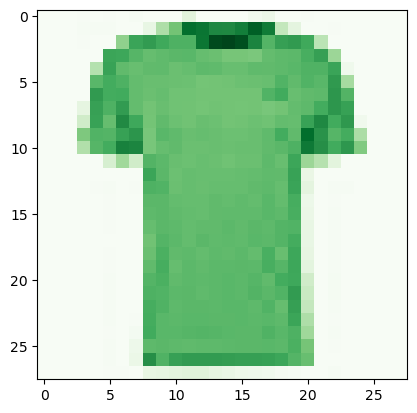

In [81]:
image = X_test[1]

prediction = predict_label(image)
label = np.argmax(prediction)

plt.imshow(image.reshape(28, 28), cmap="Greens")
plt.show()

#print(label, get_description(label))

In [25]:
def get_description(label):
    label_descriptions = {
        0: "T-shirt",
        1: "Trouser",
        2: "Pullover",
        3: "Dress",
        4: "Coat",
        5: "Sandal",
        6: "Shirt",
        7: "Sneaker",
        8: "Bag",
        9: "Ankle boot"
    }
    return label_descriptions.get(label, "Unknown label")